In [4]:
# From: https://medium.com/python-experiments/bayesian-cnn-model-on-mnist-data-using-tensorflow-probability-compared-to-cnn-82d56a298f45

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import warnings
# warnings.simplefilter(action="ignore")
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from matplotlib import figure 
from matplotlib.backends import backend_agg
import seaborn as sns
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
tf.logging.set_verbosity(tf.logging.ERROR)
# Dependency imports
import matplotlib
import tensorflow_probability as tfp
matplotlib.use("Agg")
# %matplotlib inline

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tr

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Image label: 6


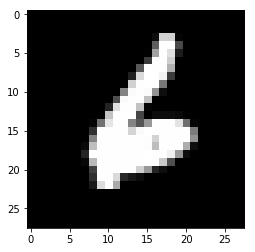

In [13]:
# ---------------------------------------------------------------------
# Preprocessing MNIST data
data_dir = "MNIST_data/"
mnist_onehot = input_data.read_data_sets(data_dir, one_hot=True)
mnist_conv = input_data.read_data_sets(data_dir,reshape=False ,one_hot=False)
mnist_conv_onehot = input_data.read_data_sets(data_dir,reshape=False ,one_hot=True)
# display an image
img_no = 485
one_image = mnist_conv_onehot.train.images[img_no].reshape(28,28)
plt.imshow(one_image, cmap='gist_gray')
print('Image label: {}'.format(np.argmax(mnist_conv_onehot.train.labels[img_no])))

In [14]:
learning_rate = 0.001   #initial learning rate
max_step = 5000 #number of training steps to run
batch_size = 50 #batch size
viz_steps = 500 #frequency at which save visualizations.
num_monte_carlo = 50 #Network draws to compute predictive probabilities.

In [15]:
# ---------------------------------------------------------------------
# Build model

images = tf.placeholder(tf.float32,shape=[None,28,28,1])
labels = tf.placeholder(tf.float32,shape=[None,])
hold_prob = tf.placeholder(tf.float32)
# define the model
neural_net = tf.keras.Sequential([
      tfp.layers.Convolution2DReparameterization(32, kernel_size=5,  padding="SAME", activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(pool_size=[2, 2],  strides=[2, 2],  padding="SAME"),
      tfp.layers.Convolution2DReparameterization(64, kernel_size=5,  padding="SAME",  activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME"),
      tf.keras.layers.Flatten(),
      tfp.layers.DenseFlipout(1024, activation=tf.nn.relu),
      tf.keras.layers.Dropout(hold_prob),
      tfp.layers.DenseFlipout(10)])
logits = neural_net(images)
# Compute the -ELBO as the loss, averaged over the batch size.
labels_distribution = tfp.distributions.Categorical(logits=logits)
neg_log_likelihood = -tf.reduce_mean(labels_distribution.log_prob(labels))
kl = sum(neural_net.losses) / mnist_conv.train.num_examples
elbo_loss = neg_log_likelihood + kl
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(elbo_loss)
# Build metrics for evaluation. Predictions are formed from a single forward
# pass of the probabilistic layers. They are cheap but noisy predictions.
predictions = tf.argmax(logits, axis=1)
accuracy, accuracy_update_op = tf.metrics.accuracy(labels=labels, predictions=predictions)

In [16]:
# ---------------------------------------------------------------------
# Run model

learning_rate = 0.001   #initial learning rate
max_step = 5000 #number of training steps to run
batch_size = 50 #batch size
viz_steps = 500 #frequency at which save visualizations.
num_monte_carlo = 50 #Network draws to compute predictive probabilities.
init_op = tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())

with tf.Session() as sess:
        sess.run(init_op)
# Run the training loop.
        for step in range(max_step+1):
            images_b, labels_b = mnist_conv.train.next_batch(
batch_size)
            images_h, labels_h = mnist_conv.validation.next_batch(
mnist_conv.validation.num_examples)
            
            _ = sess.run([train_op, accuracy_update_op], feed_dict={
                   images: images_b,labels: labels_b,hold_prob:0.5})
        if (step==0) | (step % 500 == 0):
                loss_value, accuracy_value = sess.run([elbo_loss, accuracy], feed_dict={images: images_b,
labels: labels_b,hold_prob:0.5})
                
                print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f}".format(step, loss_value, accuracy_value))

Step: 5000 Loss: 16.660 Accuracy: 0.959
